
Data Overview:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000000 entries, 2023-01-01 00:00:00 to 2137-01-29 15:00:00
Freq: h
Data columns (total 9 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   home_id                 1000000 non-null  int64  
 1   energy_consumption_kWh  1000000 non-null  float64
 2   temperature_setting_C   1000000 non-null  float64
 3   occupancy_status        1000000 non-null  object 
 4   appliance               1000000 non-null  object 
 5   usage_duration_minutes  1000000 non-null  int64  
 6   season                  1000000 non-null  object 
 7   day_of_week             1000000 non-null  object 
 8   holiday                 1000000 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 76.3+ MB
None

Missing Values:
home_id                   0
energy_consumption_kWh    0
temperature_setting_C     0
occupancy_status          0
appliance                 0
u

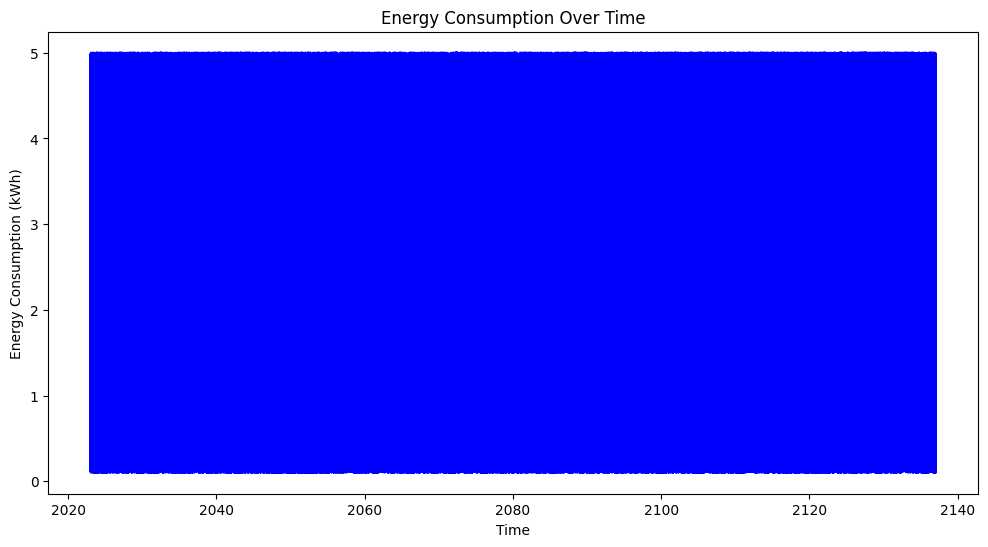

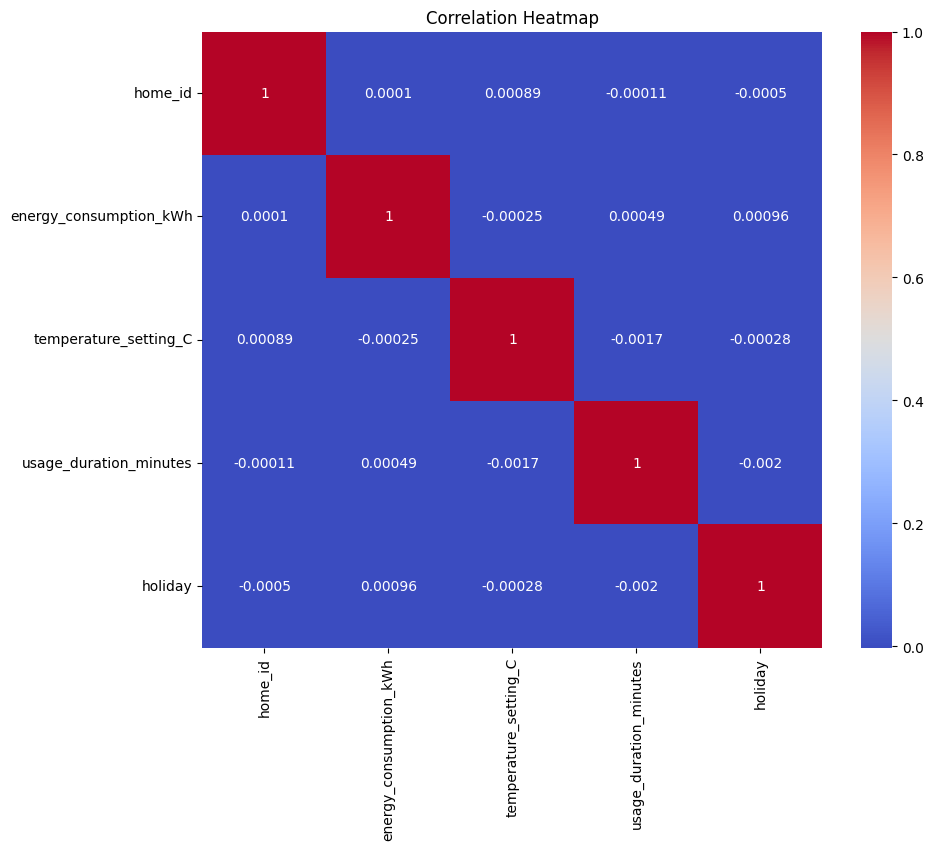

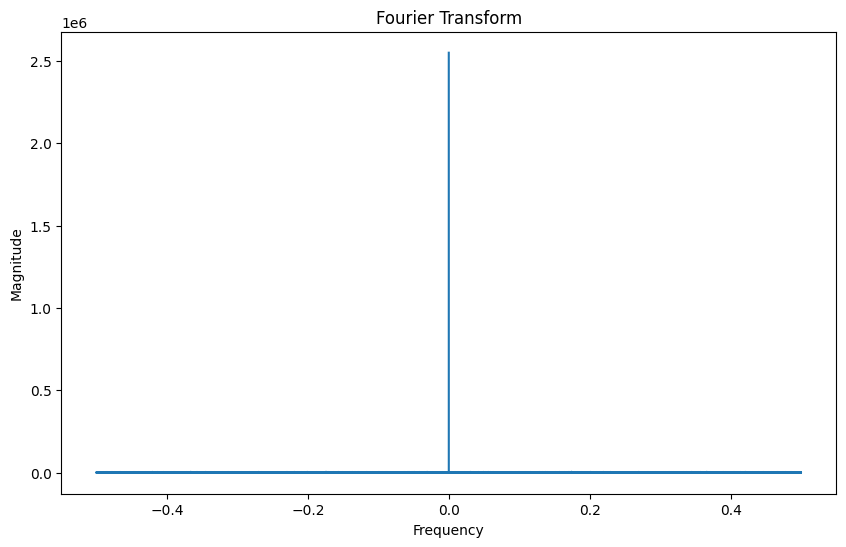

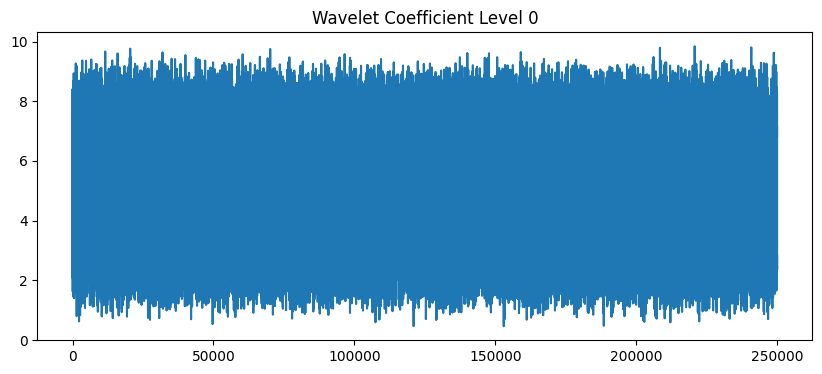

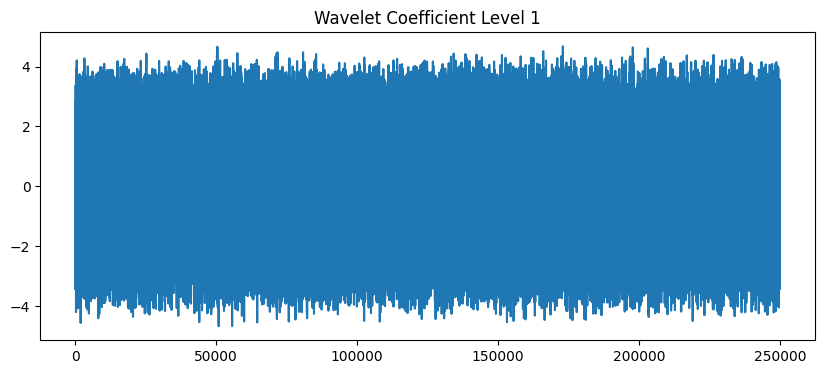

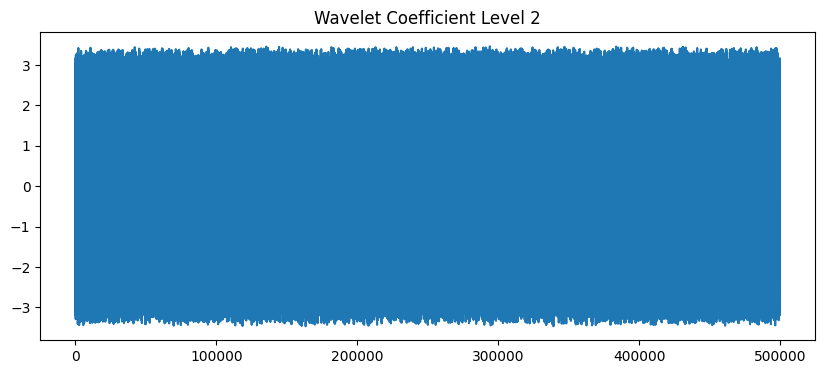

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=13.05 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=3516.440, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=3519.517, Time=1.96 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=3519.459, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=4948.914, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=3517.517, Time=1.33 sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=3517.459, Time=0.63 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=7.94 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=3518.439, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=3518.439, Time=0.45 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=3520.439, Time=0.48 sec

Best model:  ARIMA(0,0,0)(0,0,0)[24] intercept
Total fit time: 26.882 seconds


Accuracy: 49.90%


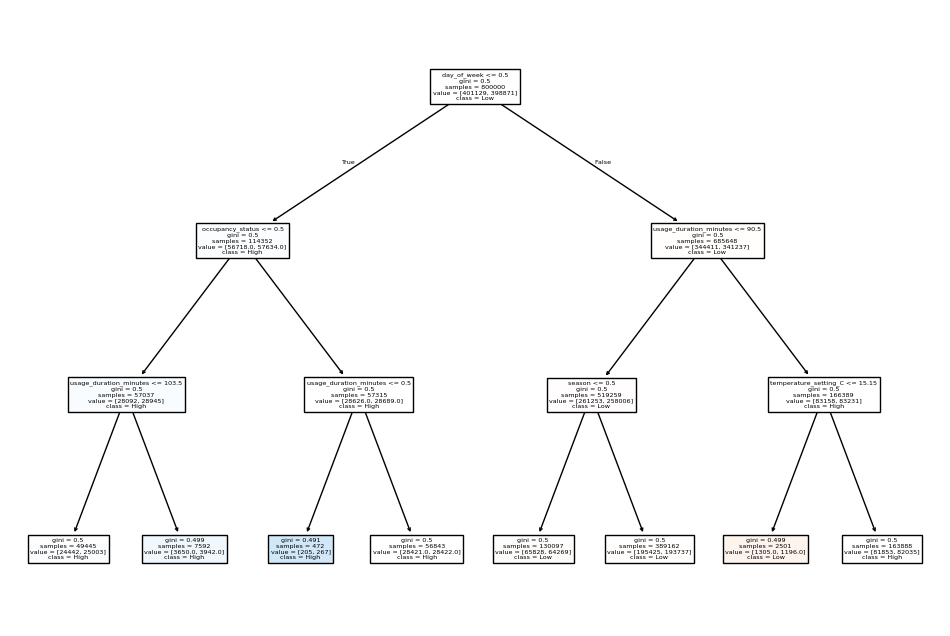

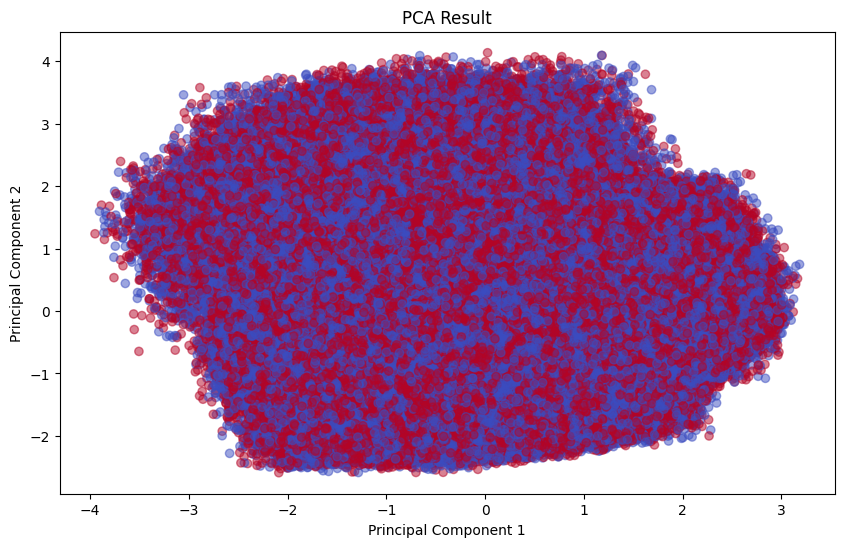

In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from statsmodels.tsa.arima.model import ARIMA
from scipy.fft import fft, ifft
from scipy.signal import butter, filtfilt
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pywt
import warnings

warnings.filterwarnings('ignore')

# Load Dataset
file_path = "C://an3.sem1//SBC.proiect//date/archive 1//smart_home_energy_usage_dataset.csv"
df = pd.read_csv(file_path)
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp']).set_index('timestamp').sort_index()
df = df.asfreq('h')
df['energy_consumption_kWh'] = df['energy_consumption_kWh'].interpolate(method='time')

# Data Overview
print("\nData Overview:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# Plot Energy Consumption
plt.figure(figsize=(12,6))
plt.plot(df.index, df['energy_consumption_kWh'], color='blue')
plt.title('Energy Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (kWh)')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Fourier Transform
energy_signal = df['energy_consumption_kWh'].values
fft_result = fft(energy_signal)
freq = np.fft.fftfreq(len(fft_result))

plt.figure(figsize=(10,6))
plt.plot(freq, np.abs(fft_result))
plt.title('Fourier Transform')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

# Wavelet Transform
coeffs = pywt.wavedec(energy_signal, 'db1', level=2)
for i, coeff in enumerate(coeffs):
    plt.figure(figsize=(10,4))
    plt.plot(coeff)
    plt.title(f'Wavelet Coefficient Level {i}')
    plt.show()

# Auto ARIMA (Optimized)
subset_data = df['energy_consumption_kWh'].dropna().tail(1000)

auto_model = auto_arima(subset_data,
                        seasonal=True,
                        m=24,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True,
                        max_p=3,
                        max_q=3,
                        max_d=2,
                        n_fits=20,
                        n_jobs=-1)

forecast = auto_model.predict(n_periods=24)

# Plot ARIMA Forecast
plt.figure(figsize=(12,6))
plt.plot(subset_data.index[-100:], subset_data[-100:], label='Actual')
plt.plot(pd.date_range(subset_data.index[-1], periods=24, freq='H'), forecast, label='Forecast')
plt.legend()
plt.title('ARIMA Forecast (Optimized)')
plt.show()

# Decision Tree Classification
df['high_consumption'] = (df['energy_consumption_kWh'] > df['energy_consumption_kWh'].median()).astype(int)
X = df.drop(columns=['energy_consumption_kWh', 'high_consumption'])
y = df['high_consumption']

# Encode Categorical Columns
for col in X.select_dtypes(include=['object', 'category']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

X_train, X_test, y_train, y_test = train_test_split(X.fillna(0), y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%')

plt.figure(figsize=(12,8))
plot_tree(clf, feature_names=X.columns, class_names=['Low', 'High'], filled=True)
plt.show()

# PCA for Dimensionality Reduction
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X.fillna(0))

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

plt.figure(figsize=(10,6))
plt.scatter(pca_result[:,0], pca_result[:,1], c=y, cmap='coolwarm', alpha=0.5)
plt.title('PCA Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# t-SNE for Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(scaled_data)

plt.figure(figsize=(10,6))
plt.scatter(tsne_result[:,0], tsne_result[:,1], c=y, cmap='coolwarm', alpha=0.5)
plt.title('t-SNE Result')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()
